# DSCI 575 Final Project
## Using Remote Sensing to Predict and Understand Future Wildfires
#### by Zeynep Ankut, Isaiah Stene, Corey Becker

Import & Setup Code


In [33]:
import importFunctions as imp 
import kagglehub

import tensorflow as tf
from tensorflow.keras import layers, models
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
from scipy.ndimage import convolve





path = kagglehub.dataset_download("fantineh/next-day-wildfire-spread")
print("Path to dataset files:", path)

train_files = path + "/next_day_wildfire_spread_train*"
test_files = path + "/next_day_wildfire_spread_test*"
eval_files = path + "/next_day_wildfire_spread_eval*"


train = imp.get_dataset(train_files,  
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

test = imp.get_dataset(test_files,  
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)


eval_data = imp.get_dataset(test_files,  
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

Path to dataset files: C:\Users\theco\.cache\kagglehub\datasets\fantineh\next-day-wildfire-spread\versions\2


In [34]:
#function to plot rows of the train data
def plotRows(start,end,titles,n_features,data):
  inputs, labels = next(iter(data))

  fig = plt.figure(figsize=(15,6.5))

  CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
  BOUNDS = [-1, -0.1, 0.001, 1]
  NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

  n_rows = end-start
  for i in range(n_rows):
    for j in range(n_features + 1):
      plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
      if i == 0:
        plt.title(titles[j], fontsize=13)
      if j < n_features - 1:
        plt.imshow(inputs[i+start, :, :, j], cmap='viridis')
      if j == n_features - 1:
        plt.imshow(inputs[i+start, :, :, -1], cmap=CMAP, norm=NORM)
      if j == n_features:
        plt.imshow(labels[i+start, :, :, 0], cmap=CMAP, norm=NORM) 
      plt.axis('off')
  plt.tight_layout()

  plt.show()

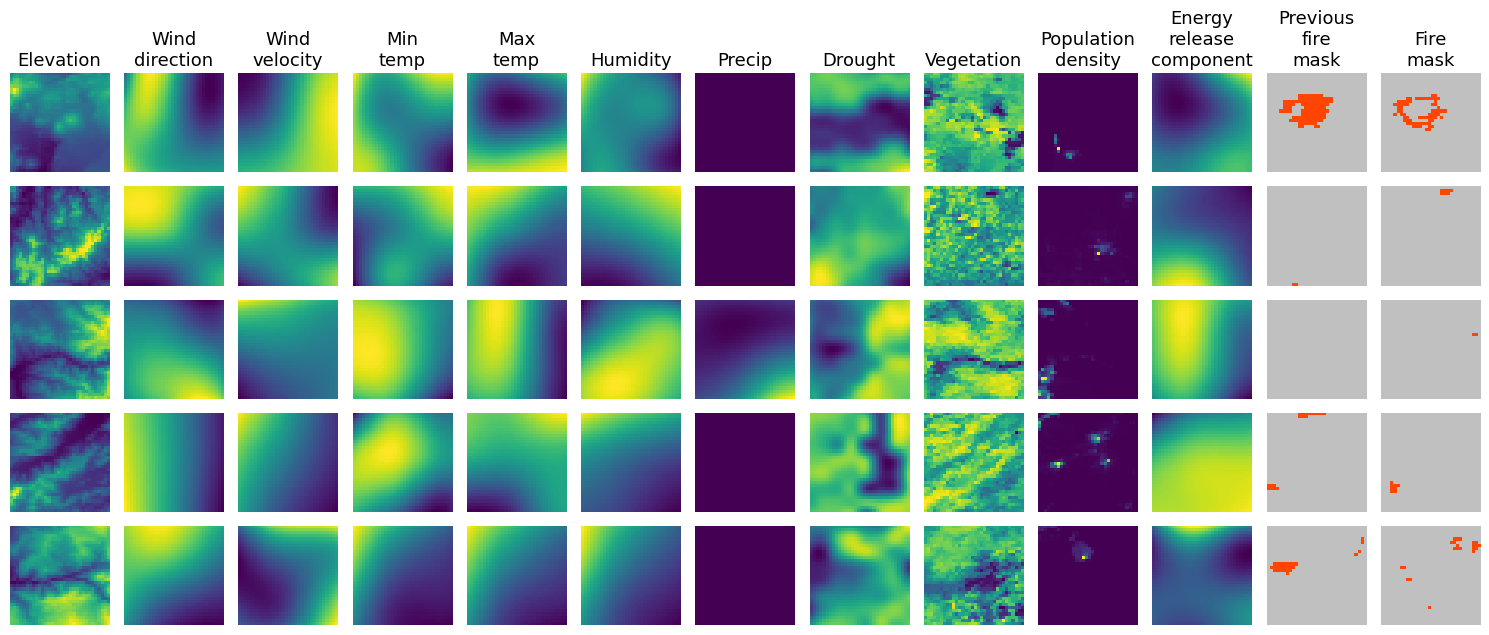

In [35]:
titles = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

plotRows(20,25,titles,len(titles)-1, train)

Data Extraction and Augmentation

In [36]:
#TRESHHOLD
THRESHOLD = .4 #what sigmoid needs to return to count it as fire

#gets the train data 
inputs, labels = next(iter(train))
indices = [0, 2, 4, 6, 7, 9, 10, 11]
tf.gather(inputs, indices, axis=-1)

#THIS IS ADDING MORE FIRE DATA TO TRAIN ON

min_fire_pixels = 15

fire_mask = labels[..., 0]  # Shape: (N, 32, 32)
fire_tiles = np.sum(fire_mask, axis=(1, 2)) > min_fire_pixels  # Shape: (N,)

copies = 2

#only gets fire data
inputs_fire = inputs[fire_tiles]
labels_fire = labels[fire_tiles]

# Duplicate them
fire_inputs_aug = np.tile(inputs_fire, (copies, 1, 1, 1))
fire_labels_aug = np.tile(labels_fire, (copies, 1, 1, 1))

# Combine with original data
inputs = np.concatenate([inputs, fire_inputs_aug], axis=0)
labels = np.concatenate([labels, fire_labels_aug], axis=0)

#gets eval data
e_inputs, e_labels = next(iter(eval_data))

#also gets eval data with fire only
min_fire_pixels_eval = 10

# Extract fire mask from eval labels
eval_fire_mask = e_labels[..., 0] 

# Boolean mask: which eval tiles have enough fire
eval_fire_tiles = np.sum(eval_fire_mask, axis=(1, 2)) > min_fire_pixels_eval

# Filter eval data
e_inputs = e_inputs[eval_fire_tiles]
e_labels = e_labels[eval_fire_tiles]

#get test data
t_inputs, t_labels = next(iter(test))

Functions to build the CNN Models

We use the UNet


In [37]:
#makes the model, keeps it simple

def build_simple_cnn(height,width, features):

    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(height, width, features)),
        layers.BatchNormalization(),


        layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(1, (1, 1), activation='sigmoid')
    ])

    return model

def build_larger_cnn(height, width, features):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(height, width, features)),
        layers.BatchNormalization(),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.SpatialDropout2D(0.2),

        layers.Conv2D(64, (3,3), dilation_rate=2, activation='relu', padding='same'),

        layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(1, (1, 1), activation='sigmoid')
    ])
    return model

def build_unet(height, width, channels):
    inputs = layers.Input(shape=(height, width, channels))

    reg = tf.keras.regularizers.l2(1e-3) #this is a small ridge regularizer

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(c1)
    # c1 = layers.Dropout(0.2)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(c2)
    c2 = layers.Dropout(0.2)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(p2)
    b = layers.Dropout(0.2)(b)
    b = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(b)

    # Decoder
    u2 = layers.UpSampling2D((2, 2))(b)
    u2 = layers.Concatenate()([u2, c2])
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(u2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(c3)
    c3 = layers.Dropout(0.2)(c3)

    u1 = layers.UpSampling2D((2, 2))(c3)
    u1 = layers.Concatenate()([u1, c1])
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(u1)
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(c4)

    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(c4)
    c5 = layers.conv2DTranpose(32, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model



    





Loss Functions, we use a combination of all 3

In [38]:
#here is the loss functions that I will use




def weighted_bce_loss(y_true,y_pred,weight_nofire=1.0,weight_fire = 10.0):
    """
        Args:
        y_true (Tensor): Ground-truth values
        y_pred (Tensor): Predited values
        weight_nofire (float): Weight of class 0 (no-fire)
        weight_fire (float): Weight of class 1 (fire)
        
    """
    bin_crossentropy = K.binary_crossentropy(y_true, y_pred)

    weights = y_true * weight_fire + (1.0 - y_true) * weight_nofire
    weight_bce = weights * bin_crossentropy

    return K.mean(weight_bce,axis = 1)


def dice_loss(y_true,y_pred):
    BATCH_SIZE = 32
    smooth = 1e-6

    y_true_f = K.reshape(y_true, (BATCH_SIZE, -1))
    y_pred_f = K.reshape(y_pred, (BATCH_SIZE, -1))
    
    intersection = K.sum(y_true_f * y_pred_f, axis=1)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f, axis=1) + K.sum(y_pred_f, axis=1) + smooth)
    

def focal_loss(y_true, y_pred, alpha=0.75, gamma=2.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    return tf.reduce_mean(-alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt))

def combined_loss(y_true,y_pred):
    #this is a combined loss function, so these weights can be messed with to proritize one loss function over the others
    d_weight = 1.25
    bce_weight = .75
    focal_weight = 1.25
    return d_weight * dice_loss(y_true,y_pred) + bce_weight * weighted_bce_loss(y_true,y_pred) + focal_weight * focal_loss(y_true,y_pred)

In [39]:
#this removes all the no data points, gets it to be all 1's or zeros

def shift_data(labels):
    return tf.maximum(labels,tf.constant([0.]))

Functions for metrics


In [40]:
#TF METRIC VERSION


def iou_m(y_true,y_pred):
    """
    Calculation of intersection over union metric.
    
    Args:
        y_true (Tensor): true fire mask
        y_pred  (Tensor): predicted mask
    Returns:
        (float): IoU metric 
    """
    y_pred = tf.cast(y_pred > THRESHOLD, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = tf.math.divide_no_nan(intersection, union)
    return iou

def recall_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > THRESHOLD, tf.float32)
    y_true = tf.cast(tf.where(y_true < 0, 0.0, y_true), tf.float32)

    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
    actual_positives = tf.reduce_sum(y_true)

    recall = tf.math.divide_no_nan(true_positives, actual_positives)
    return recall

def precision_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > THRESHOLD, tf.float32)
    y_true = tf.cast(tf.where(y_true < 0, 0.0, y_true), tf.float32)

    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
    predicted_positives = tf.reduce_sum(y_pred)

    precision = tf.math.divide_no_nan(true_positives, predicted_positives)
    return precision

def f1_m(y_true, y_pred):
    prec = precision_m(y_true, y_pred)
    rec = recall_m(y_true, y_pred)
    f1 = tf.math.divide_no_nan(2 * prec * rec, prec + rec)
    return f1


Build and Fit the Model


In [41]:
#build the model 
n_fires, height,width, feat_images = inputs.shape

# model = build_segmentation_cnn(height,width,feat_images,2)
model = build_larger_cnn(height,width,feat_images)

labels = shift_data(labels)

labels_fire = shift_data(labels_fire)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss = combined_loss, 
              metrics = ['accuracy', precision_m, recall_m, f1_m,iou_m])


In [42]:
#do the fit

n_epoch = 50 #too many epochs overfit very badly

#stops epochs early if the test loss gets worse
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=30,#num epochs of worse val lose before stopping
                                            min_delta=0.001, # minimum change to qualify as improvement
                                            restore_best_weights=True,
                                            verbose = True)

#this reduces the learning rate once the data plataues
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    inputs,
    labels,
    validation_data = (e_inputs,e_labels),
    epochs = n_epoch,
    batch_size = 16,
    verbose = True,
    callbacks=[
        early_stop,
        reduce_lr
    ]

)

best_epoch = early_stop.stopped_epoch - early_stop.patience

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 242ms/step - accuracy: 0.4883 - f1_m: 0.0546 - iou_m: 0.0282 - loss: 2.2803 - precision_m: 0.0286 - recall_m: 0.6831 - val_accuracy: 0.1212 - val_f1_m: 0.0745 - val_iou_m: 0.0387 - val_loss: 3.2447 - val_precision_m: 0.0388 - val_recall_m: 0.9435 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.5601 - f1_m: 0.0550 - iou_m: 0.0283 - loss: 1.9951 - precision_m: 0.0285 - recall_m: 0.8627 - val_accuracy: 0.2197 - val_f1_m: 0.0740 - val_iou_m: 0.0384 - val_loss: 2.6812 - val_precision_m: 0.0386 - val_recall_m: 0.8881 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.6832 - f1_m: 0.0596 - iou_m: 0.0308 - loss: 1.9226 - precision_m: 0.0309 - recall_m: 0.8795 - val_accuracy: 0.5988 - val_f1_m: 0.0551 - val_iou_m: 0.0282 - val_loss: 2.1778 - val_precision_m: 0.0294 - val_recall_m: 0.4569 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 

Plot Results

In [43]:
#plot the training
def plot_training_history(history,best_epoch):
    """
    Plots loss and all other metrics in model history.
    Accepts a `history` object returned by model.fit().
    """
    history_dict = history.history
    metrics = [m for m in history_dict.keys() if not m.startswith('val_') and m != 'loss']

    # best_epoch = history.callbacks

    # Plot Loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.axvline(x=best_epoch, ls = '--', label = "Best Epoch", color = "#CBC318" )
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Train Metrics
    plt.figure(figsize=(10, 4))
    for metric in metrics:
        plt.plot(history.history[metric], label=f'Train {metric}')
    plt.axvline(x=best_epoch, ls = '--', label = "Best Epoch", color = "#CBC318" )
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title('Training Metrics over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Validation Metrics
    plt.figure(figsize=(10, 4))
    for metric in metrics:
        val_metric = f'val_{metric}'
        if val_metric in history.history:
            plt.plot(history.history[val_metric], label=f'Validation {metric}')
    plt.axvline(x=best_epoch, ls = '--', label = "Best Epoch", color = "#CBC318" )
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title('Validation Metrics over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


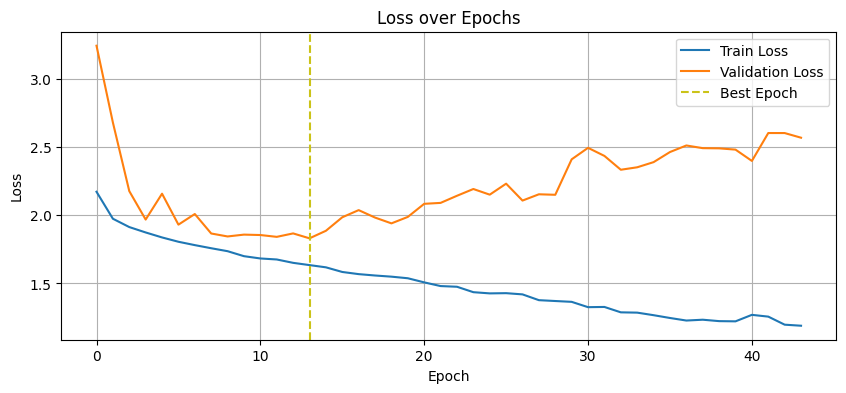

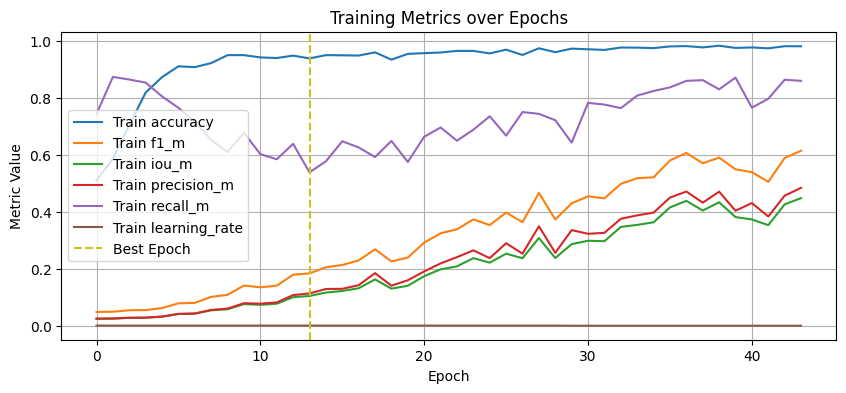

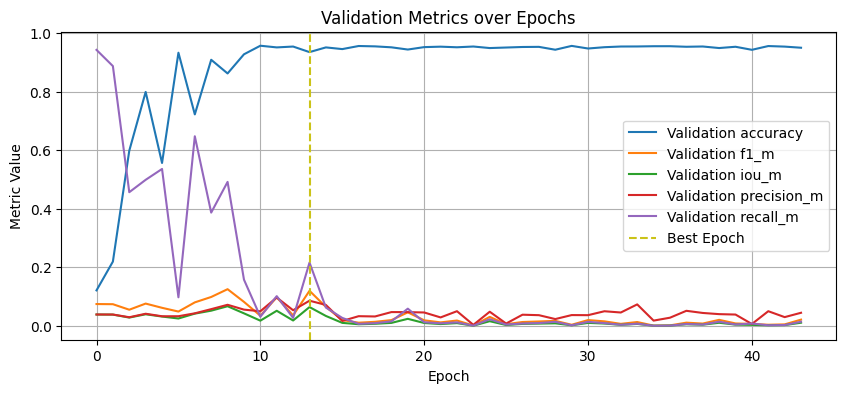

In [44]:
plot_training_history(history, best_epoch)

In [45]:
#plot results


def PlotPredictions(start,end,label,prediction):
  """
  plots pairs of images, one for the actual fire mask, and the next for the predicted firemask from our model.

  Args:
  start (int): the index of the first firemask to use
  end (int): the index of the last fire mask to use, non-inclusive
  label: the actual fire mask
  prediction: the predicted fire mask from the model
  """
    
  n_plots = end - start
  fig, axes = plt.subplots(n_plots, 2, figsize=(12, 4 * n_plots))
  # norm2 = colors.Normalize(vmin=0, vmax=1)  


  CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
  BOUNDS = [-1, -0.1, 0.001, 1]
  NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)


  for i in range(n_plots):
    #actual fire mask
    axes[i,0].imshow(label[i+start,:,:,0],cmap=CMAP,norm=NORM)
    axes[i, 0].set_title(f"Actual Fire Mask {i + start} ")
    axes[i, 0].axis('off')

    #handles prediction, each prediction has a vector of [p_noFire,p_fire], we will use whatever one is larger
    axes[i,1].imshow(prediction[start+i,:,:]>THRESHOLD,cmap=CMAP,norm=NORM)
    axes[i, 1].set_title(f"predicted Fire Mask {i + start}")
    axes[i, 1].axis('off')

  plt.tight_layout()
  plt.show()


def show_preds(inputs, labels, preds, index=0):
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    axs[0].imshow(inputs[index, :, :, -1], cmap=CMAP, norm=NORM)
    axs[0].set_title("Previous Fire Mask")
    
    axs[1].imshow(labels[index, :, :, 0], cmap=CMAP, norm=NORM)
    axs[1].set_title("True Fire Mask")

    axs[3].imshow(preds[index, :, :, 0], cmap='inferno')
    axs[3].set_title("Predicted Fire Prob.")

    axs[2].imshow(preds[index, :, :, 0]>THRESHOLD, cmap=CMAP, norm=NORM)
    axs[2].set_title("Predicted Fire Mask")
    
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


  

This is Train Data


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step


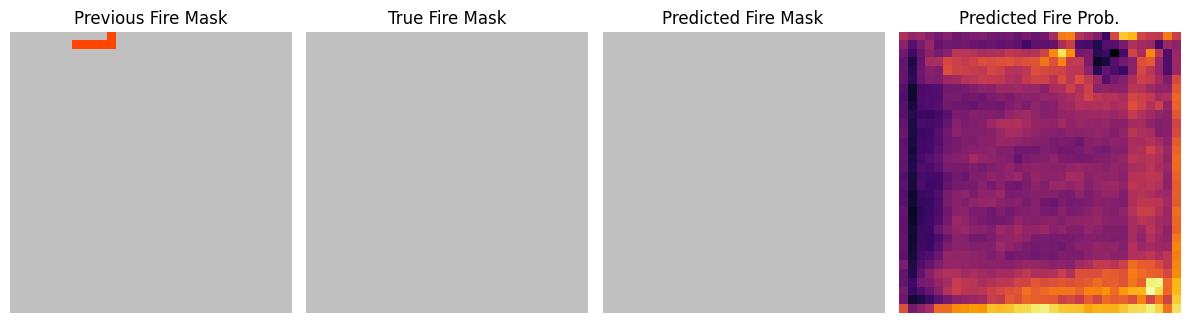

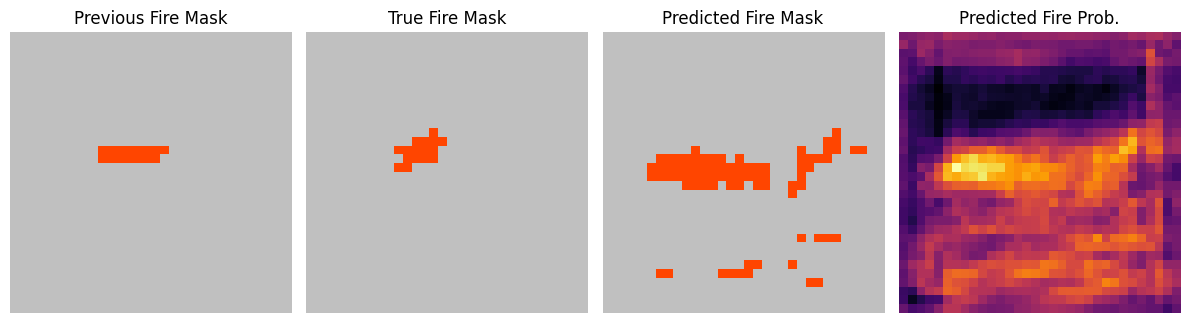

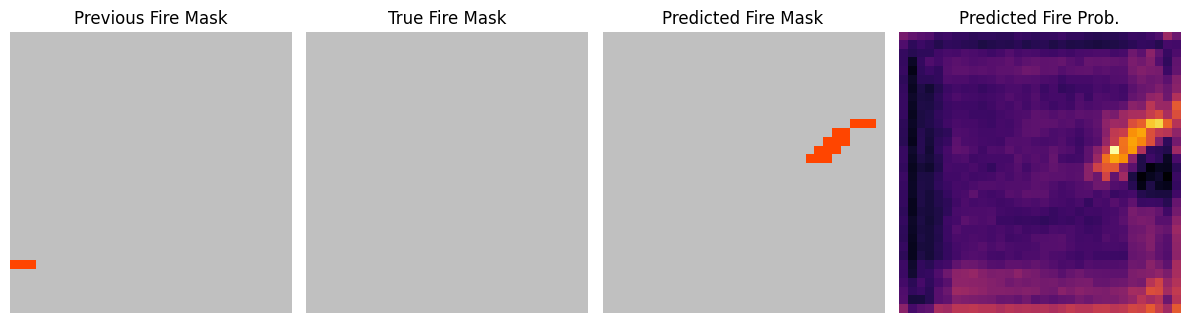

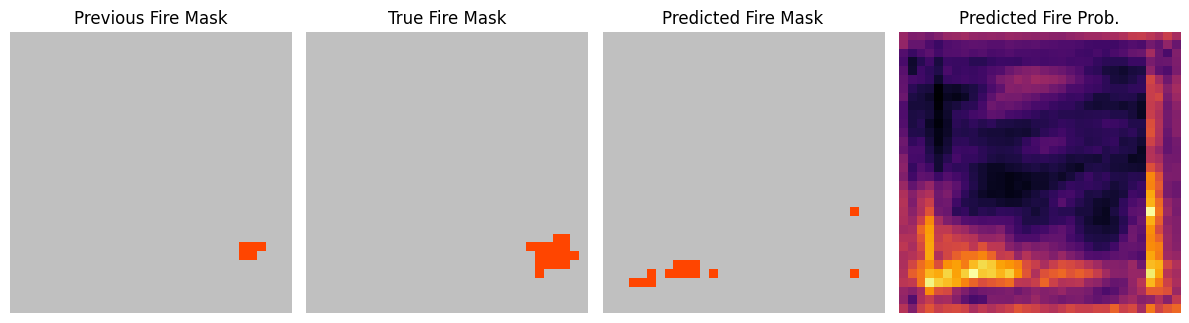

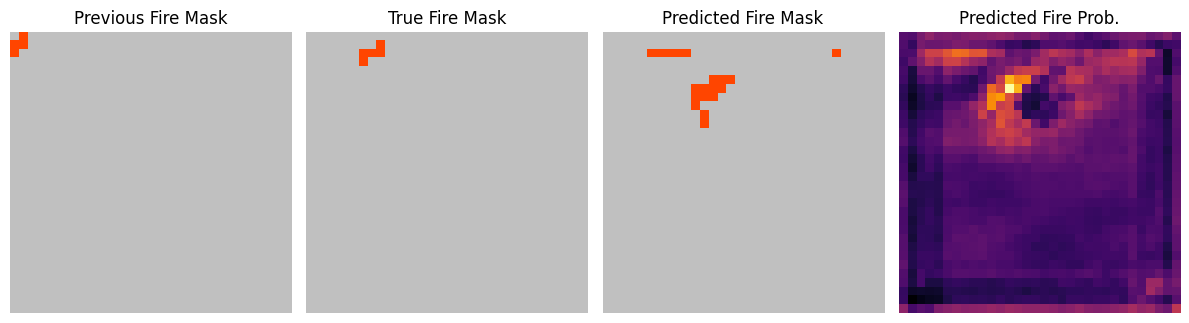

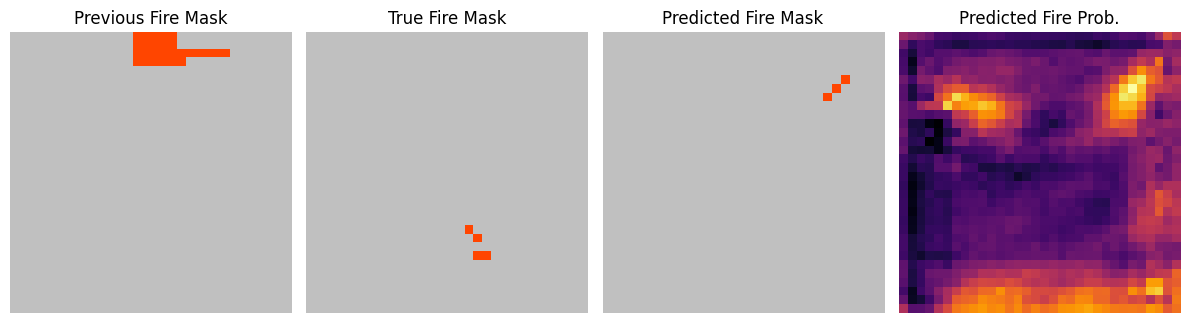

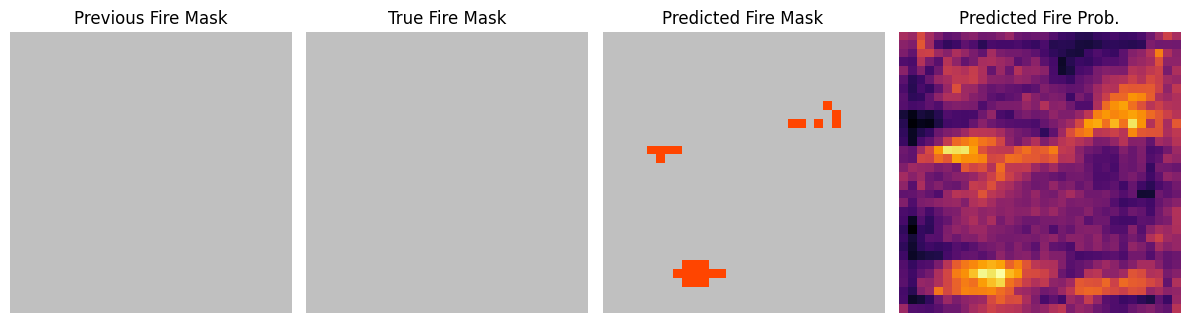

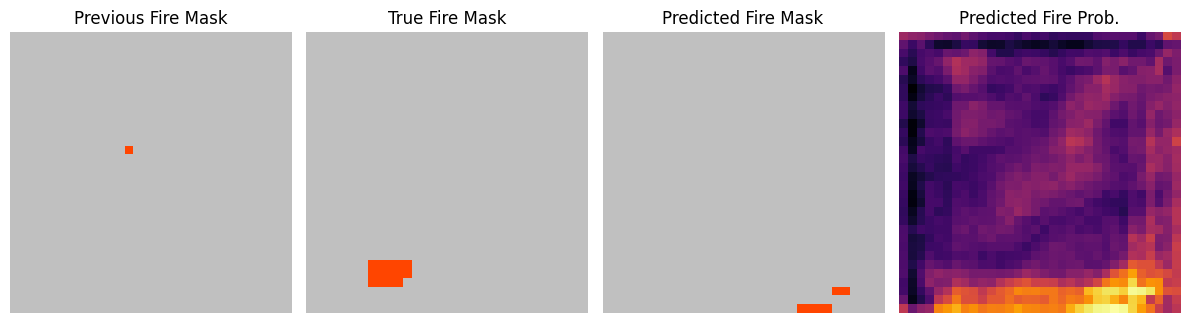

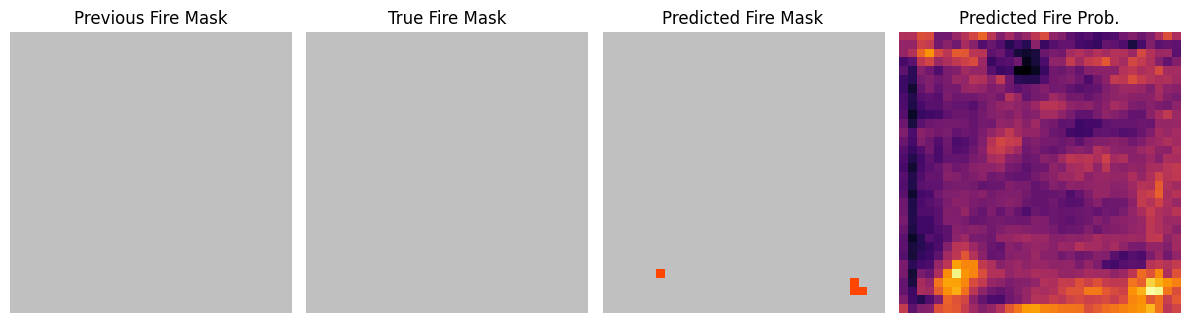

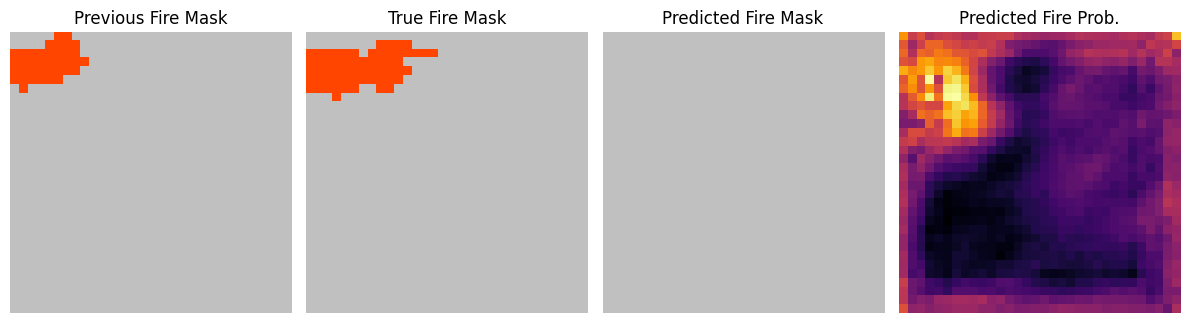

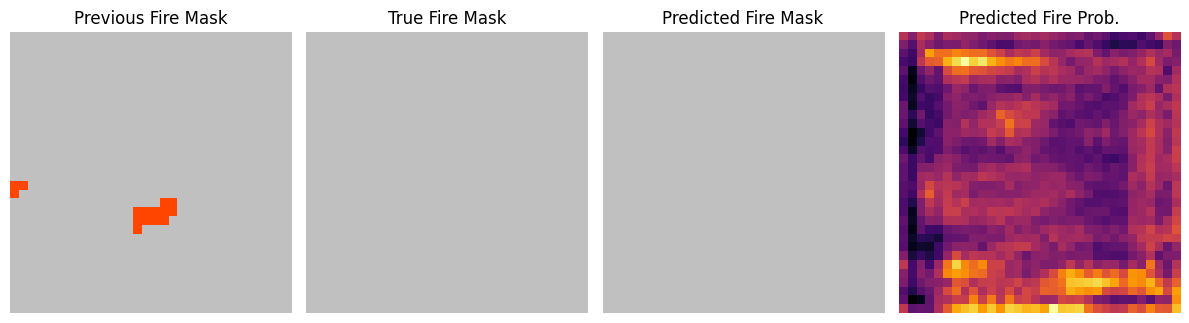

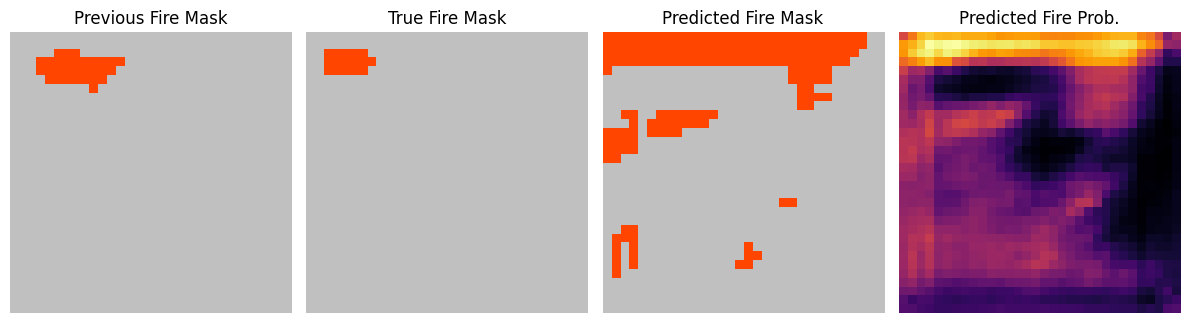

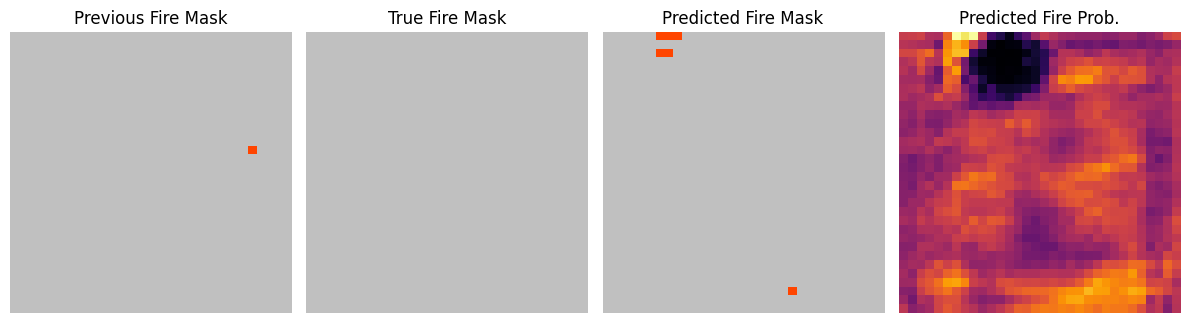

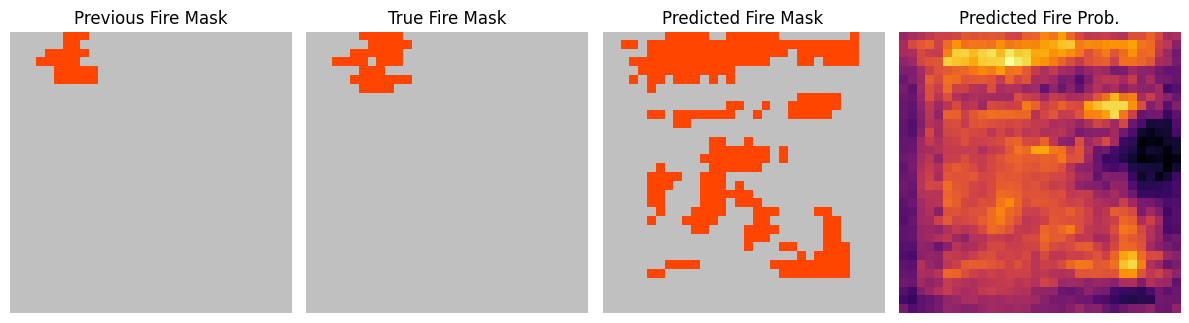

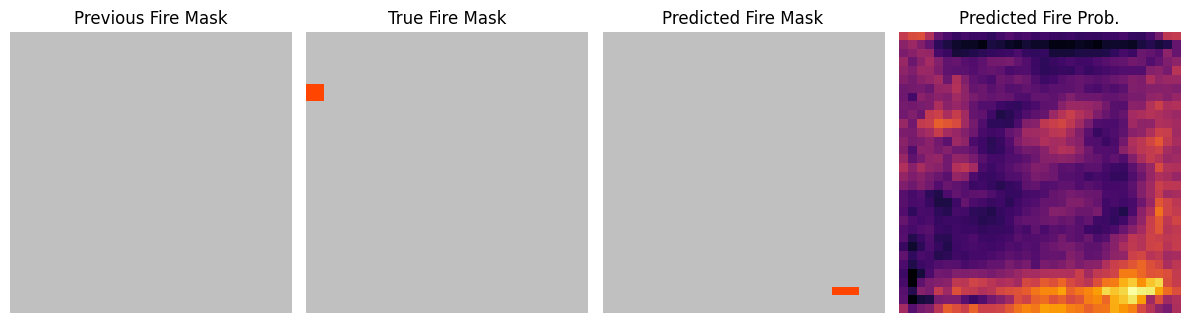

In [46]:
pMask = model.predict(inputs)


#apply neigborhood filtering

# filtered_preds = np.array([
#     neighborhood_filter(mask, threshold=0.2, required_fraction=0.2)
#     for mask in pMask[:,:,:,0]
# ])


# plotRows(0,5,titles,len(titles)-1, train)
# PlotPredictions(0,15,labels,pMask)
# PlotPredictions(0,15,labels,filtered_preds)
for i in range(15):
    show_preds(inputs,labels,pMask,index = i)


Test Data

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


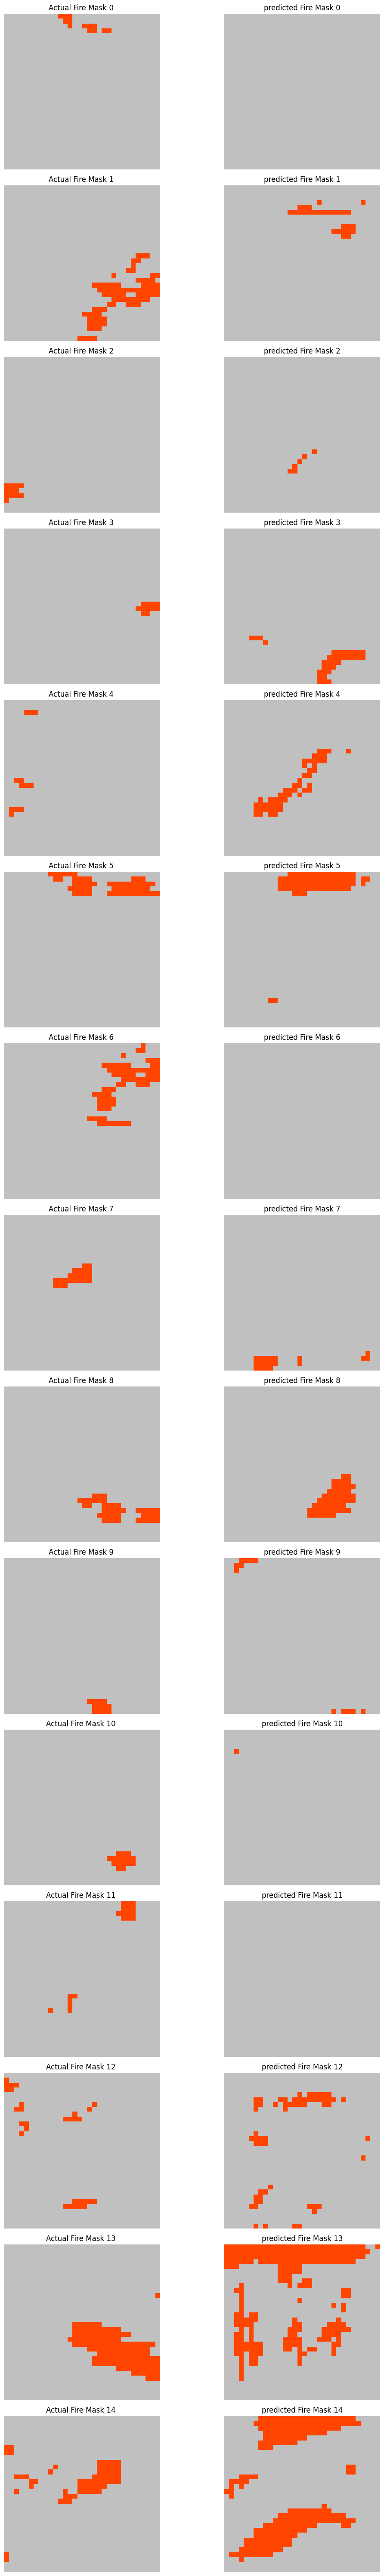

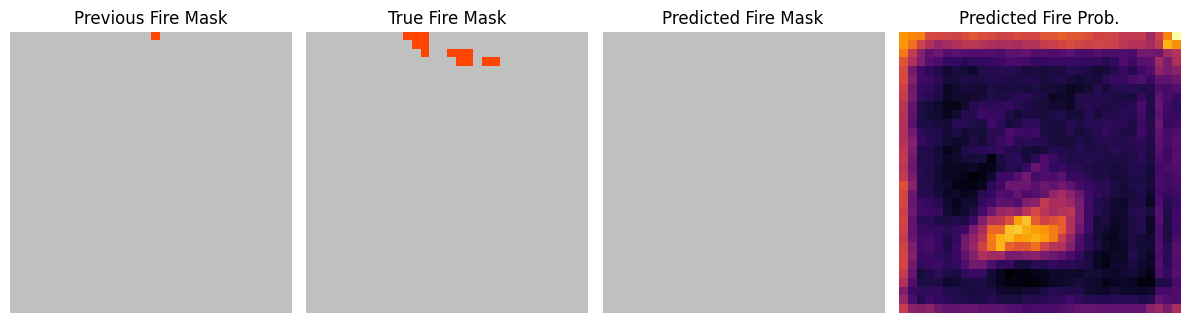

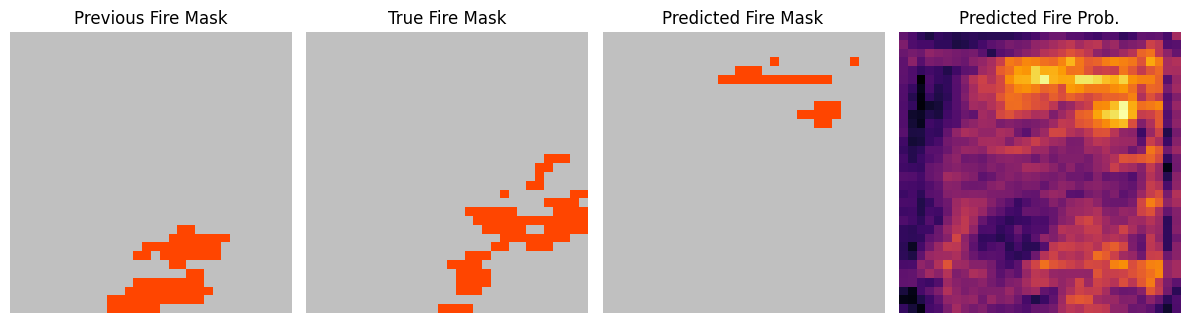

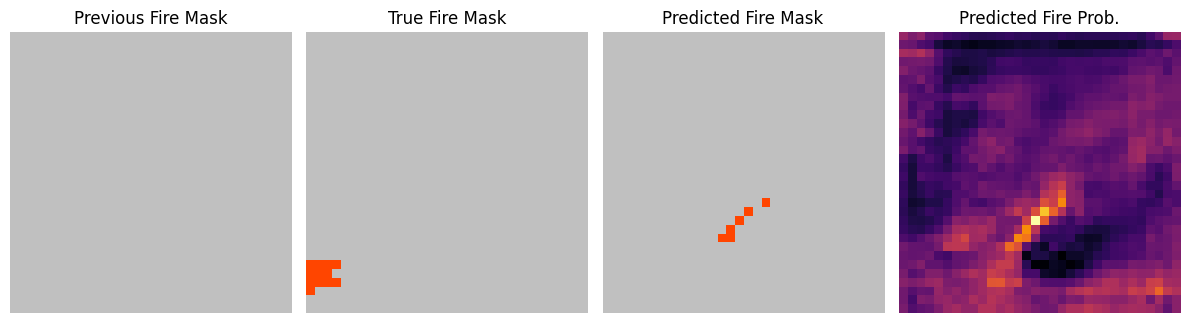

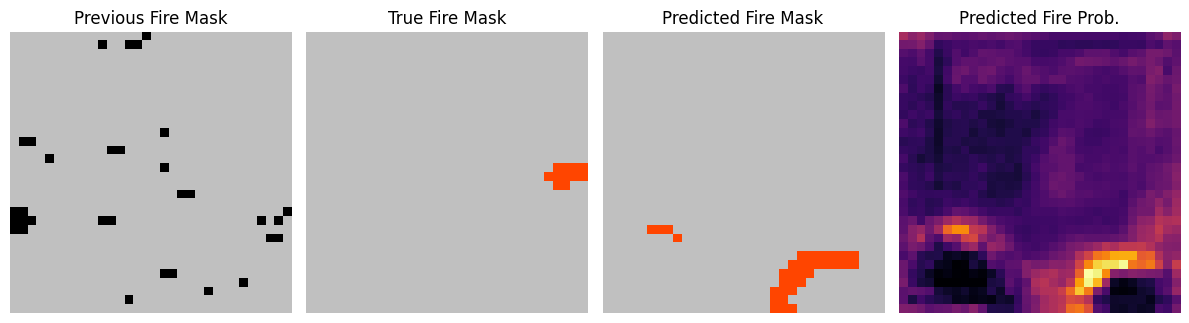

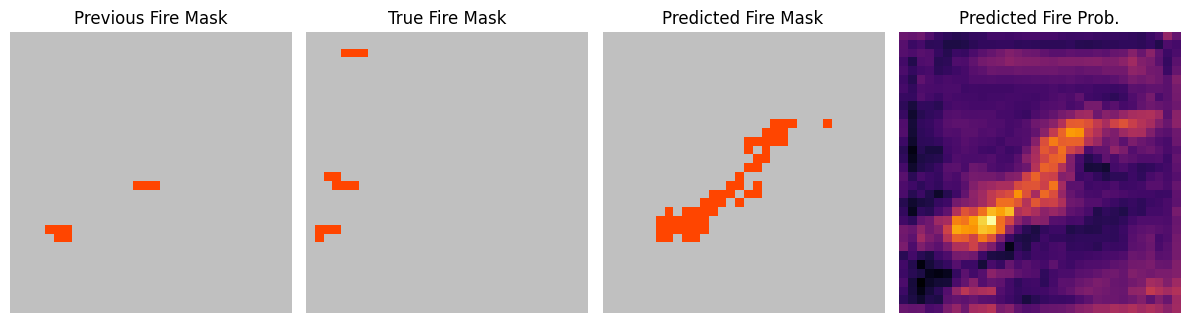

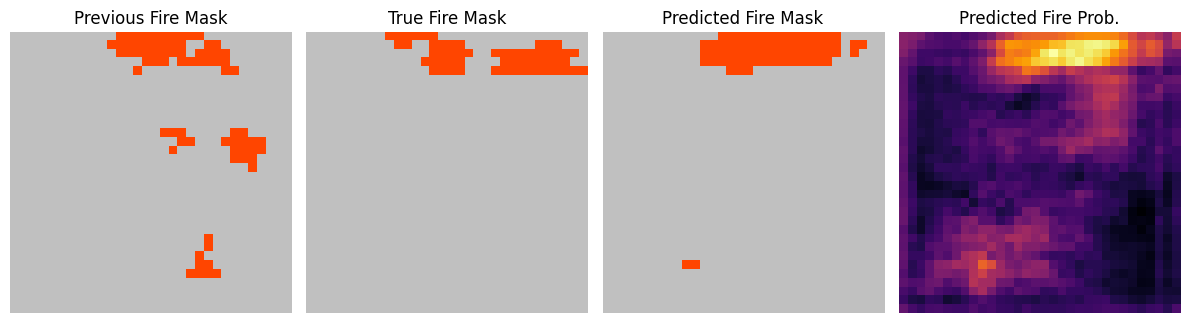

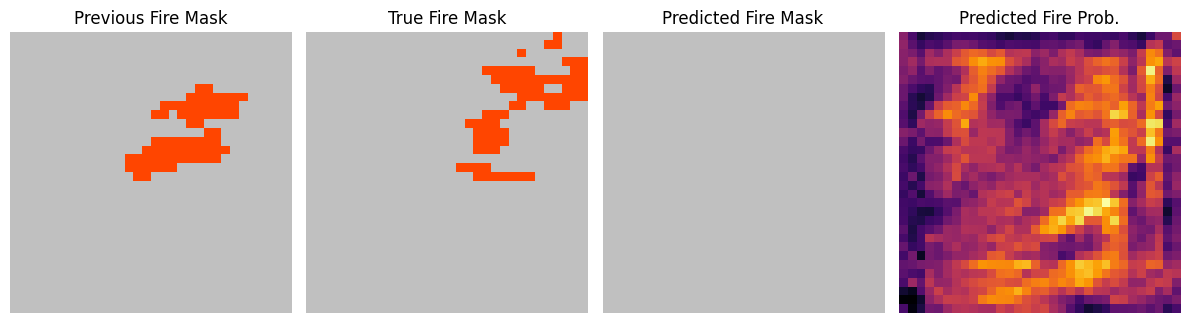

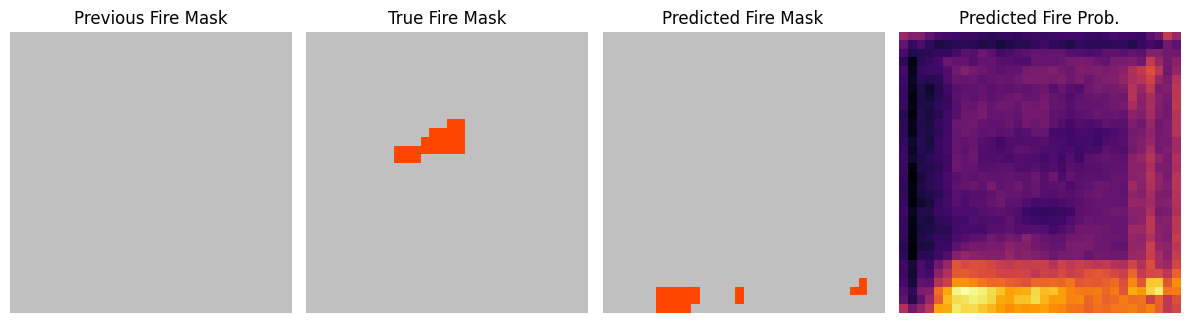

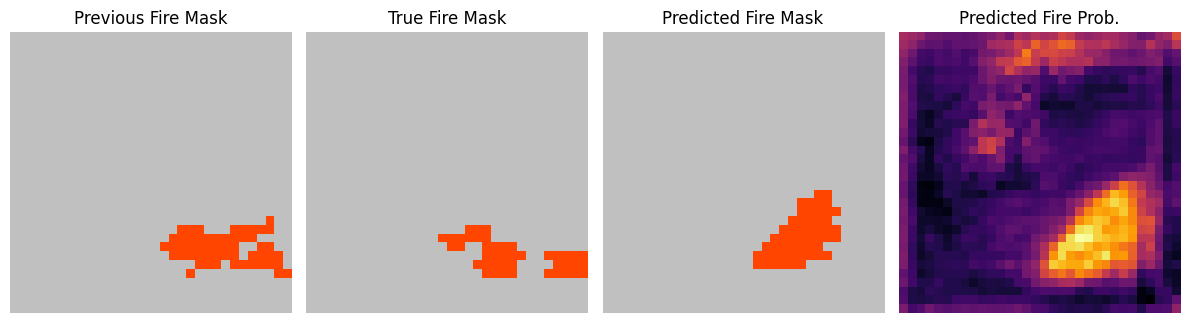

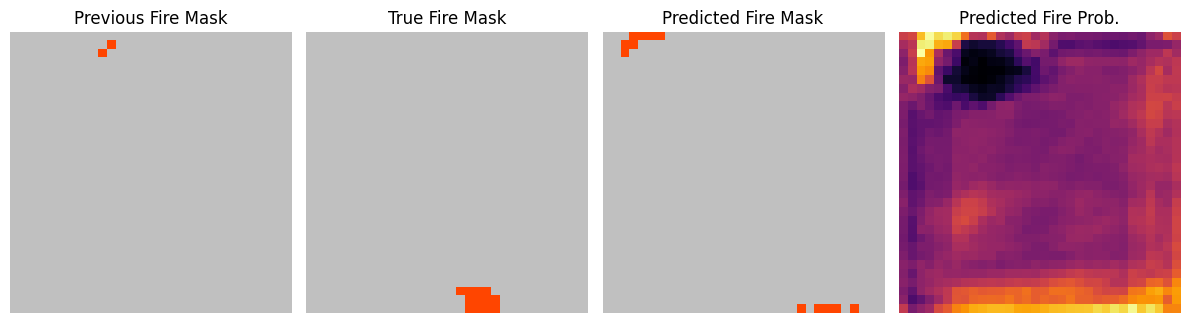

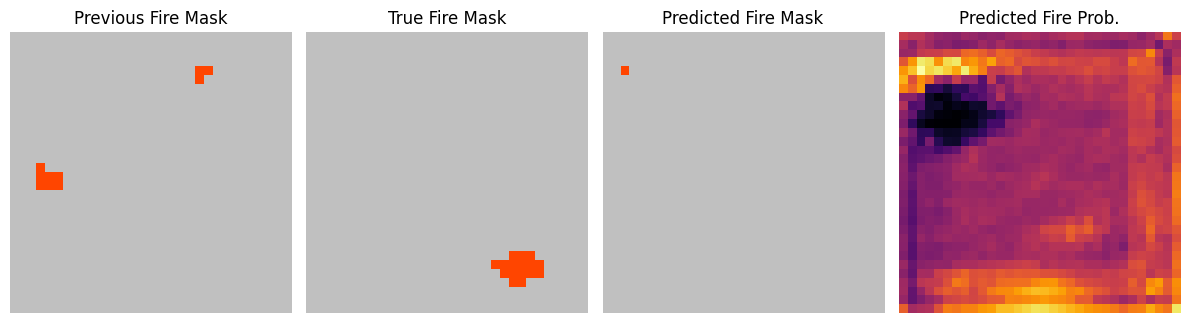

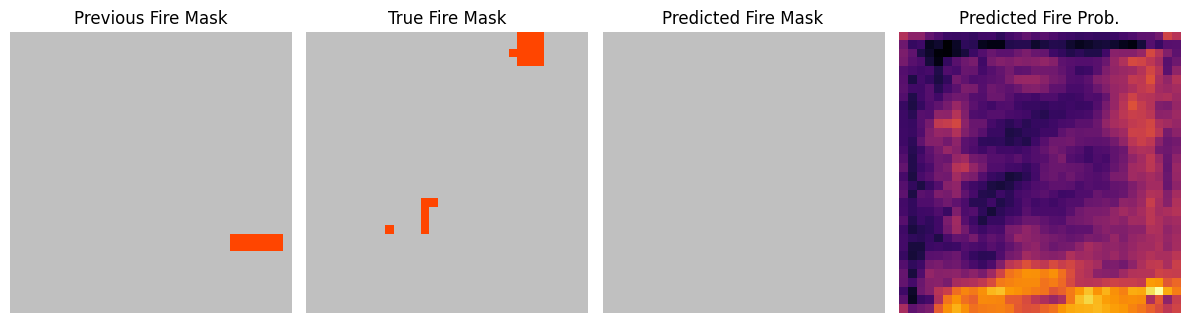

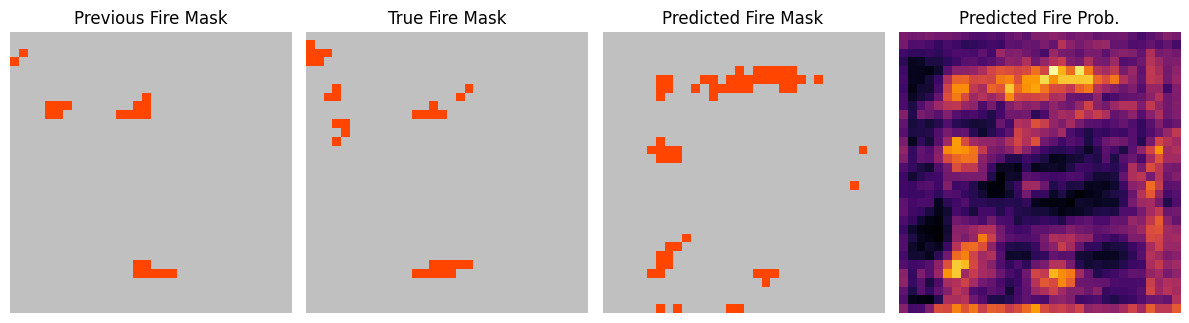

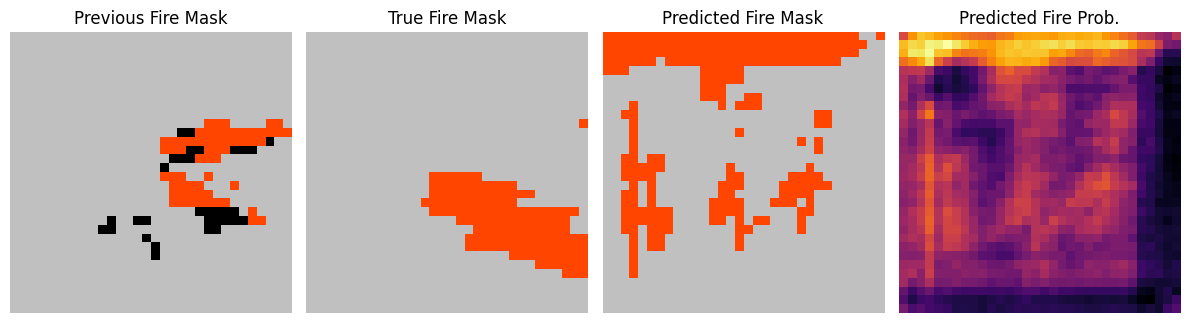

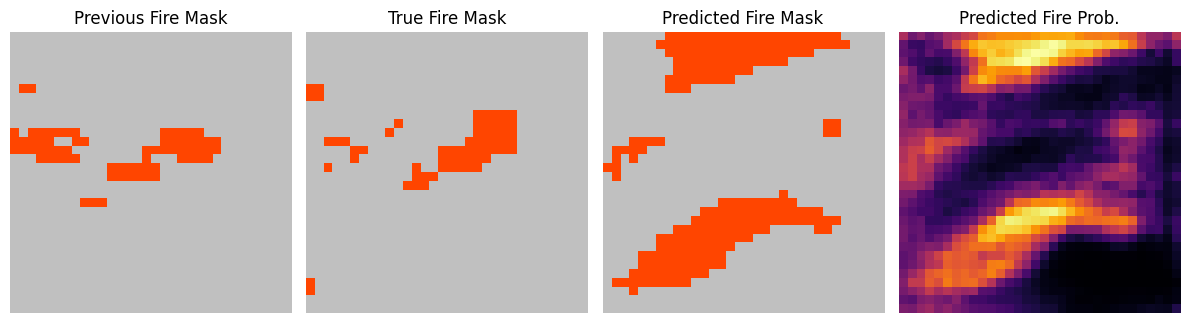

In [47]:
pMask_eval = model.predict(e_inputs)

PlotPredictions(0,15,e_labels,pMask_eval)
# PlotPredictions(0,15,labels,filtered_preds)
for i in range(15):
    show_preds(e_inputs,e_labels,pMask_eval,index = i)